# Data Preparation (Using Edge Histograms)

## Imports

In [468]:
import os
import glob
import numpy as np
from skimage import io
from skimage import color, filters, exposure

## Edge Histograms (From Programming Assignment 1)

In [469]:
def load_and_grayscale(image_path):
    image = io.imread(image_path)
    grayscaled_image = color.rgb2gray(image)
    
    return grayscaled_image

def angle(dx, dy):
    return np.mod(np.arctan2(dy, dx), np.pi)

def edge_angle(image):
    sobel_h = filters.sobel_h(image)
    sobel_v = filters.sobel_v(image)
    angle_sobel = angle(sobel_h, sobel_v)
    return angle_sobel

def compute_histogram(image_angle):
    hist, bin_centers = exposure.histogram(image_angle, nbins=36)
    return hist, bin_centers

def all_to_histograms(image_files):
    histograms_list = []
    labels = []
    
    for i, image_path in enumerate(image_files):
        class_label_full = os.path.basename(os.path.dirname(image_path))
        class_label = class_label_full.split('-')[1]
        class_label = class_label.replace('_', ' ')
        labels.append(class_label.title())
        
        grayscaled_image = load_and_grayscale(image_path)
        angle_sobel = edge_angle(grayscaled_image)
        hist, bin_centers = compute_histogram(angle_sobel)

        histograms_list.append(hist)

    return histograms_list, labels

## Run

In [470]:
images_folder = './data/Images/*/*'
image_files = glob.glob(images_folder)

all_histograms, labels = all_to_histograms(image_files)
histograms = np.array(all_histograms)

# Splitting and Standardization

## Imports

In [624]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Splitting for Training and Testing

In [625]:
unique_labels = np.unique(labels)
label_mapping = {label: i for i, label in enumerate(unique_labels)}
encoded_labels = np.array([label_mapping[label] for label in labels])

X_train, X_test, y_train, y_test = train_test_split(histograms, encoded_labels, test_size=0.2, train_size=0.8, random_state=42)


## Standardization

In [626]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Performance Comparison

## Imports

In [627]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt


## Stratified 5-Fold Cross-Validation

In [628]:
skf = StratifiedKFold(n_splits=5)

## Decision Tree Classifier

In [629]:
dt_clf = DecisionTreeClassifier(max_depth=10, random_state=42)

dt_scores = cross_val_score(dt_clf , X_train, y_train, cv=skf, scoring='accuracy')
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
dt_cm = confusion_matrix(y_test, dt_pred)

dt_cv_mean = dt_scores.mean()
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred, average='weighted')

print(f"Decision Tree Mean Validation Accuracy: {dt_cv_mean * 100:.2f}%")
print(f"Decision Tree Accuracy: {dt_accuracy * 100:.2f}%")
print(f"Decision Tree F-Measure: {dt_f1 * 100:.2f}%")

Decision Tree Mean Validation Accuracy: 29.90%
Decision Tree Accuracy: 29.92%
Decision Tree F-Measure: 30.09%


## Neural Network Classifier 

In [630]:
nn_clf = MLPClassifier(hidden_layer_sizes=(10, 10, 10), random_state=42, max_iter=1000)

nn_scores = cross_val_score(nn_clf, X_train, y_train, cv=skf, scoring='accuracy')
nn_clf.fit(X_train, y_train)
nn_pred = nn_clf.predict(X_test)
nn_cm = confusion_matrix(y_test, nn_pred)

nn_cv_mean = nn_scores.mean()
nn_accuracy = accuracy_score(y_test, nn_pred)
nn_f1 = f1_score(y_test, nn_pred, average='weighted')

print(f"Neural Network Mean Validation Accuracy: {nn_cv_mean * 100:.2f}%")
print(f"Neural Network Accuracy: {nn_accuracy * 100:.2f}%")
print(f"Neural Network F-Measure: {nn_f1 * 100:.2f}%")

Neural Network Mean Validation Accuracy: 32.28%
Neural Network Accuracy: 37.80%
Neural Network F-Measure: 36.51%


## Adaboost Classifier

In [631]:
ab_clf = AdaBoostClassifier(algorithm='SAMME',random_state=42)

ab_scores = cross_val_score(ab_clf, X_train, y_train, cv=skf, scoring='accuracy')
ab_clf.fit(X_train, y_train)
ab_pred = ab_clf.predict(X_test)
ab_cm = confusion_matrix(y_test, ab_pred)

ab_cv_mean = ab_scores.mean()
ab_accuracy = accuracy_score(y_test, ab_pred)
ab_f1 = f1_score(y_test, ab_pred, average='weighted')

print(f"AdaBoost Mean Validation Accuracy: {ab_cv_mean * 100:.2f}%")
print(f"AdaBoost Accuracy: {ab_accuracy * 100:.2f}%")
print(f"AdaBoost F-Measure: {ab_f1 * 100:.2f}%")

AdaBoost Mean Validation Accuracy: 32.87%
AdaBoost Accuracy: 30.71%
AdaBoost F-Measure: 30.91%


## Three Confusion Matrices

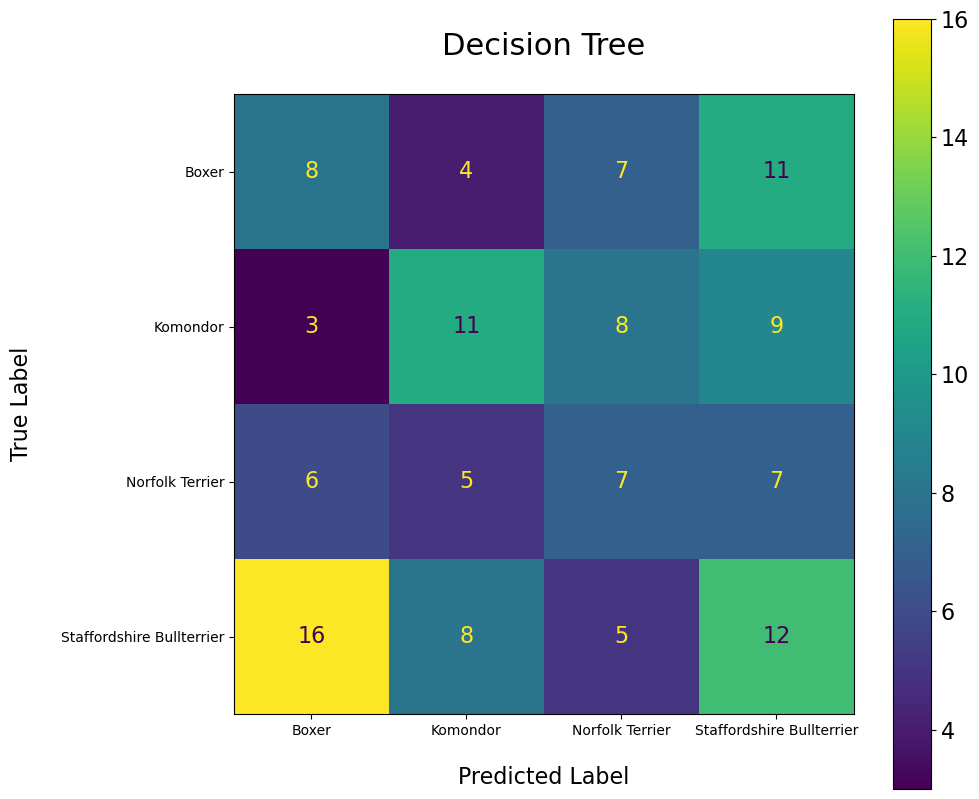

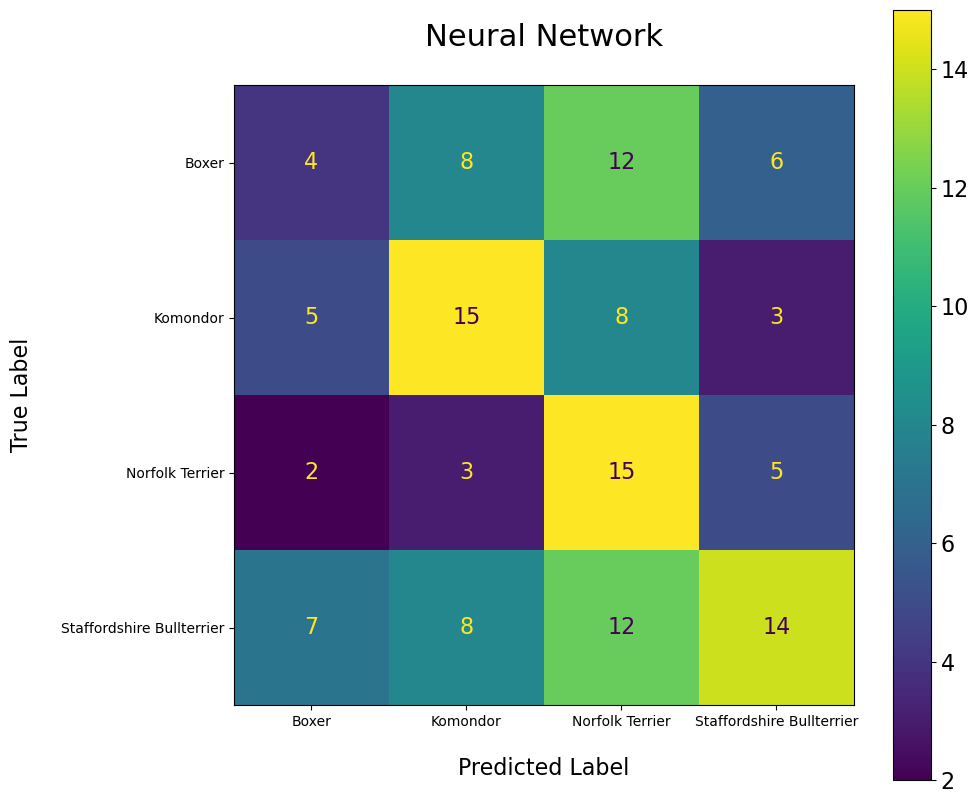

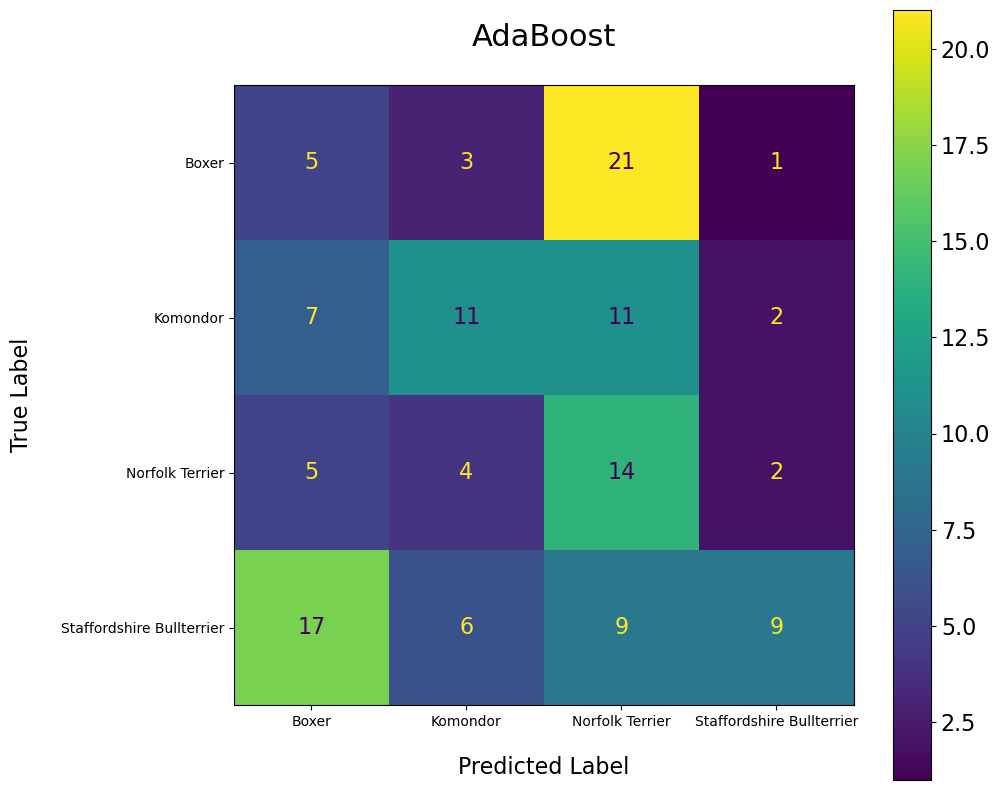

In [632]:
titles = ['Decision Tree', 'Neural Network', 'AdaBoost']
confusion_matrices = [dt_cm, nn_cm, ab_cm]

for cm, title in zip(confusion_matrices, titles):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax)
    
    plt.title(title, fontsize = 22, y=1.05)
    plt.xlabel('Predicted Label', fontsize=16, labelpad=20)
    plt.ylabel('True Label', fontsize=16, labelpad=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    plt.show()


## Conclution

- **Visual Comparison of Confusion Matrices**: The Neural Network classifier shows the most accurate predictions along the diagonal in 3 out of 4 classes, indicating that it aligns well with the true labels. Although each classifier has some misclassifications, the Neural Network generally demonstrates higher alignment with the true values.

- **Mean Validation Accuracy**: The Neural Network classifier has the highest average accuracy across the 5-fold cross-validation.

- **Test Accuracy**: With the highest accuracy on the test set, the Neural Network seems to be the most reliable.

- **F-Measure**: The F-measure results additionally confirm the Neural Network’s superior performance.

# Model Selection

## Imports

In [633]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold


## Initialization/Data Preparation

In [634]:
C_values = [0.1, 1, 10, 100]

training_errors = {'standard': [], 'stratified': []}
validation_errors = {'standard': [], 'stratified': []}

selected_classes = [1,2]
train_mask = np.isin(y_train, selected_classes)
test_mask = np.isin(y_test, selected_classes)

X_train_filt = X_train[train_mask]
y_train_filt = y_train[train_mask]
X_test_filt = X_test[test_mask]
y_test_filt = y_test[test_mask]


## 5-Fold Cross-Validations

In [635]:
for C in C_values:
    model = LinearSVC(C=C)

    # Standard Cross-Validation
    kf = KFold(n_splits=5)
    train_errors, val_errors = [], []
    for train_idx, val_idx in kf.split(X_train_filt, y_train_filt):
        model.fit(X_train_filt[train_idx], y_train_filt[train_idx])
        train_pred = model.predict(X_train_filt[train_idx])
        val_pred = model.predict(X_train_filt[val_idx])
        train_errors.append(1 - accuracy_score(y_train_filt[train_idx], train_pred))
        val_errors.append(1 - accuracy_score(y_train_filt[val_idx], val_pred))
    training_errors['standard'].append(np.mean(train_errors) * 100)
    validation_errors['standard'].append(np.mean(val_errors) * 100)

    # Stratified Cross-Validation
    skf = StratifiedKFold(n_splits=5)
    train_errors, val_errors = [], []
    for train_idx, val_idx in skf.split(X_train_filt, y_train_filt):
        model.fit(X_train_filt[train_idx], y_train_filt[train_idx])
        train_pred = model.predict(X_train_filt[train_idx])
        val_pred = model.predict(X_train_filt[val_idx])
        train_errors.append(1 - accuracy_score(y_train_filt[train_idx], train_pred))
        val_errors.append(1 - accuracy_score(y_train_filt[val_idx], val_pred))
    training_errors['stratified'].append(np.mean(train_errors) * 100)
    validation_errors['stratified'].append(np.mean(val_errors) * 100)

## Plotting

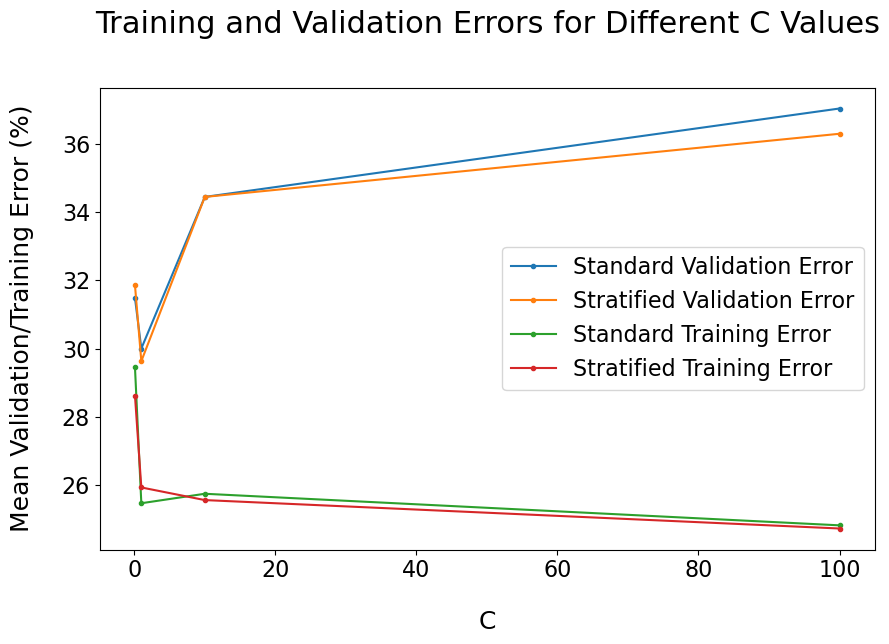

In [636]:
plt.figure(figsize=(10, 6))
plt.plot(C_values, validation_errors['standard'], label="Standard Validation Error", marker='.')
plt.plot(C_values, validation_errors['stratified'], label="Stratified Validation Error", marker='.')
plt.plot(C_values, training_errors['standard'], label="Standard Training Error", marker='.')
plt.plot(C_values, training_errors['stratified'], label="Stratified Training Error", marker='.')

plt.xlabel("C", fontsize = 18, labelpad=20)
plt.ylabel("Mean Validation/Training Error (%)", fontsize = 18, labelpad=20)
plt.legend()
plt.title("Training and Validation Errors for Different C Values", fontsize = 22, y=1.10)
plt.show()

## Graph Comment

The **'Stratified Validation Error'** has the lowest mean error among 'Validation Error' curves and the **'Stratified Training Error'** has the lowest mean error among 'Training Error' curves.

1. With lower C values (0.1 and 1), both training and validation errors are higher, suggesting underfitting initially. As C increases, training errors drop, showing that the model is better capturing the training data patterns. However, the corresponding validation errors increase around the same level, which can be a sign that higher C values may be leading the model to memorize the training data more, reducing its generalization.

2. The difference between training and validation errors is not drastic, but the pattern indicates that the model could overfit more if C were increased further.

## Testing with the Selected C Value

In [637]:
C = C_values[np.argmin(validation_errors['stratified'])]

final_model = LinearSVC(C=C, max_iter=1000, random_state=42)

final_model.fit(X_train_filt, y_train_filt)
test_pred = final_model.predict(X_test_filt)
test_error = 1 - accuracy_score(y_test_filt, test_pred)

print(f"Test Dataset Error (C={C}): {test_error * 100:.2f}%")

Test Dataset Error (C=1): 32.14%
